[ 4264667.40600782  1178194.38894084   -74684.02765904  1733809.2209839
   677119.04668925  -494801.26646048  -144874.69247988   182843.878554
    16725.05485349   -48861.98832198   -30686.3893362     -6742.96967827
   -12154.25802401]
[ 4264667.40600782  1178194.38894084   -74684.02765904  1733809.2209839
   677119.04668925  -494801.26646048  -144874.69247988   182843.878554
    16725.05485349   -48861.98832198   -30686.3893362     -6742.96967827
   -12154.25802401]
[ 4264667.40600782  1178194.38894084   -74684.02765904  1733809.2209839
   677119.04668925  -494801.26646048  -144874.69247988   182843.878554
    16725.05485349   -48861.98832198   -30686.3893362     -6742.96967827
   -12154.25802401]
[ 4264667.40600782  1178194.38894084   -74684.02765904  1733809.2209839
   677119.04668925  -494801.26646048  -144874.69247988   182843.878554
    16725.05485349   -48861.98832198   -30686.3893362     -6742.96967827
   -12154.25802401]
[ 4264667.40600782  1178194.38894084   -74684.02765904  

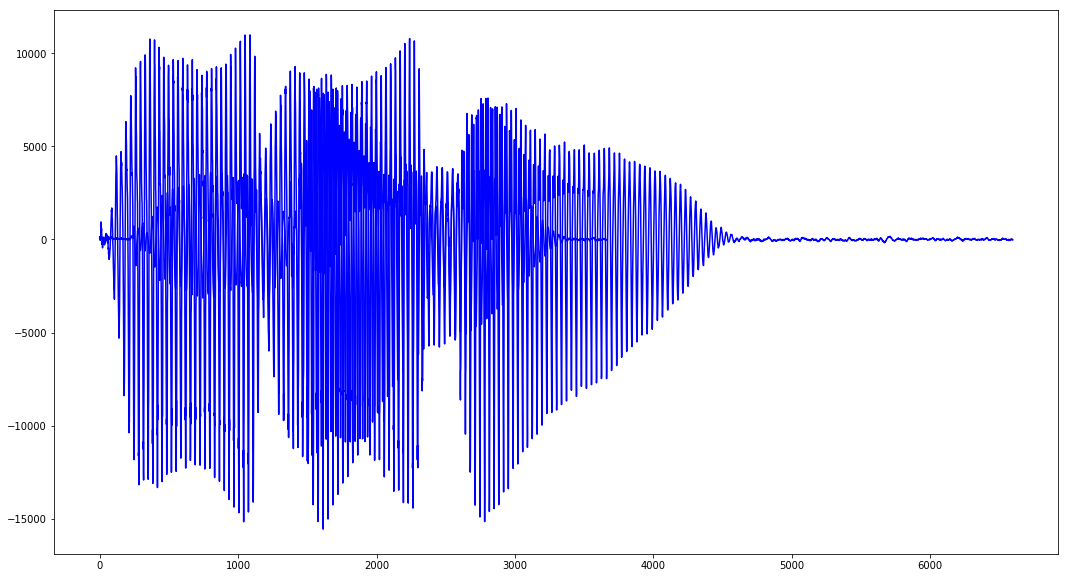

In [19]:
%matplotlib inline
from scipy import signal
from scipy.io.wavfile import write,read
import matplotlib.pyplot as plt
import math
import numpy as np
import IPython
from numpy import convolve
from scipy.signal import hamming
from scipy.ndimage.interpolation import shift
from scipy.linalg import toeplitz,inv
from scipy.fftpack import fft,fftshift,ifft,dct

def get_mel_filters(N,num_filts,Fs,freq_down=300,freq_up=4000):
    up_melcoef=1125*np.log(1+freq_up/700)
    down_melcoef=1125*np.log(1+freq_down/700)
    filtbank_mel=np.linspace(down_melcoef,up_melcoef,num_filts+2)
    filtbank_hz=700*(np.exp(filtbank_mel/1125)-1)
    #print (filtbank_hz)
    filtbank_bins=np.floor((N+1)*filtbank_hz/Fs)
    #print (filtbank_bins)
    #Computing filters now
    filters=np.zeros(shape=(num_filts,N))
    for i in range(1,num_filts//2+1):
        fp=int(filtbank_bins[i-1])
        sp=int(filtbank_bins[i])
        tp=int(filtbank_bins[i+1])
        filters[i-1]=np.hstack((np.zeros(fp),np.linspace(0,1,sp-fp+1),np.linspace(1,0,tp-sp+1)[1:],np.zeros(N-tp-1))).ravel()
        #plt.plot(filters[i-1])
    return filters

def feat_ext(digit,num_wav,Fs):
    
    # Parameters
    N=512
    num_filts=26
    mel_filters=get_mel_filters(N//2+1,num_filts,Fs)
    t_analysis=0.01
    num_samp=int(Fs*t_analysis)

    for samp_under_analysis in range(1,num_wav+1):

        filename="./Processed_Data/"+str(digit)+"/"+str(samp_under_analysis)+".wav"
        read_wav = read(filename)
        inp=np.array(read_wav[1],dtype='float64')
        plt.rcParams["figure.figsize"] = (18,10)
        plt.plot(inp,'blue')
        num_feat=int(inp.size/num_samp)
        
        for i in range(num_feat):
    
            if(i==0):
                st_ind=i*(num_feat)
            end_ind=st_ind+num_samp            
            frame=inp[st_ind:end_ind]
            #---------------------------------------------------------
            #Windowed DFT
            zero_arr=np.zeros(N-num_samp)
            zero_pd=np.append(frame,zero_arr)
            hamm_w=np.append(hamming(num_samp),np.zeros((N-num_samp)))
            s_n=zero_pd*hamm_w ## x[n]=s[n]w[n]
            S_k=fft(s_n)
            P_k=(np.abs(S_k[0:257])*np.abs(S_k[0:257]))/num_samp
            #---------------------------------------------------------
            #Computing MFCC
            energy_fbank=[np.sum(P_k*mel_filters[i]) for i in range(num_filts//2)]
            #---------------------------------------------------------
            # DCT
            mfcc=dct(energy_fbank)
            print(mfcc)
            
feat_ext(0,2,8000)
            